In [1]:
# pip install PIL

In [2]:
!pip install tensorflow==2.8
!apt-get install libcudnn8

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import time 
import datetime


from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, Activation, UpSampling2D 
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.compat.v1.enable_eager_execution()

In [4]:
# Load the images from paths
# prevedi da ovo nisu tensor funkcije 
@tf.function
def get_input_and_output_images(input_image_path, output_image_path):
    input_image = tf.io.decode_png(tf.io.read_file(input_image_path), channels = 3)
    input_image = tf.image.convert_image_dtype(input_image, tf.float64)
    input_image = tf.image.resize(input_image, [224, 224])
    input_image = tf.reshape(input_image, [224, 224, 3])         
    
    output_image = tf.io.decode_png(tf.io.read_file(output_image_path), channels = 1)
    output_image = tf.image.convert_image_dtype(output_image, tf.float64)
    output_image = tf.image.resize(output_image, [224, 224])
    output_image = tf.reshape(output_image, [224, 224, 1])
    
    return input_image, output_image

In [5]:
input_shape = (224, 224, 3)
image_shape = [224, 224]

BATCH_SIZE = 16
BUFFER_SIZE = 150
repeat_count = None

num_threads = 4

EPOCHS = 21
learning_rate=1e-5
patience = 10

In [6]:
data_path = r"../datasets"

checkpoint_path = r"../Model_checkpoints/Model_mask_detection_smaller/"

In [7]:
### A1
input_images_A1 =  [data_path + "/A1/smaller/" + f for f in os.listdir(data_path + "/A1/smaller") if f.endswith("_rgb.png")]
output_images_A1 = [f.replace("_rgb", "_fg") for f in input_images_A1]

print(len(input_images_A1))
print(len(output_images_A1))


### A2
input_images_A2 =  [data_path + "/A2/smaller/" + f for f in os.listdir(data_path + "/A2/smaller") if f.endswith("_rgb.png")]
output_images_A2 = [f.replace("_rgb", "_fg") for f in input_images_A2]

print(len(input_images_A2))
print(len(output_images_A2))


### A4
input_images_A4 =  [data_path + "/A4/smaller/" + f for f in os.listdir(data_path + "/A4/smaller") if f.endswith("_rgb.png")]
output_images_A4 = [f.replace("_rgb", "_fg") for f in input_images_A4]

print(len(input_images_A4))
print(len(output_images_A4))

print(output_images_A4)

128
128
31
31
624
624
['../datasets/A4/smaller/plant0001_fg.png', '../datasets/A4/smaller/plant0002_fg.png', '../datasets/A4/smaller/plant0003_fg.png', '../datasets/A4/smaller/plant0004_fg.png', '../datasets/A4/smaller/plant0005_fg.png', '../datasets/A4/smaller/plant0006_fg.png', '../datasets/A4/smaller/plant0007_fg.png', '../datasets/A4/smaller/plant0008_fg.png', '../datasets/A4/smaller/plant0009_fg.png', '../datasets/A4/smaller/plant0010_fg.png', '../datasets/A4/smaller/plant0011_fg.png', '../datasets/A4/smaller/plant0012_fg.png', '../datasets/A4/smaller/plant0013_fg.png', '../datasets/A4/smaller/plant0014_fg.png', '../datasets/A4/smaller/plant0015_fg.png', '../datasets/A4/smaller/plant0016_fg.png', '../datasets/A4/smaller/plant0017_fg.png', '../datasets/A4/smaller/plant0018_fg.png', '../datasets/A4/smaller/plant0019_fg.png', '../datasets/A4/smaller/plant0020_fg.png', '../datasets/A4/smaller/plant0021_fg.png', '../datasets/A4/smaller/plant0022_fg.png', '../datasets/A4/smaller/plant00

In [8]:
input_images = np.concatenate([input_images_A1, input_images_A2, input_images_A4]) 
output_images = np.concatenate([output_images_A1, output_images_A2, output_images_A4]) 

# input_images = input_images_A1
# output_images = output_images_A1

print(len(input_images))
print(len(output_images))
# print(input_images)
# print(output_images)

783
783


In [9]:
X_train, X_rem, y_train, y_rem = train_test_split(input_images, output_images, random_state = 219, shuffle=True, test_size= 0.20)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, random_state = 271, shuffle = True, test_size = 0.50)

# print(y_test)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(len(val_dataset))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(train_dataset)

2022-08-26 14:57:04.867296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 14:57:05.601771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [11]:
train_dataset = train_dataset.map(get_input_and_output_images, num_parallel_calls=num_threads)
val_dataset = val_dataset.map(get_input_and_output_images, num_parallel_calls=num_threads)
test_dataset = test_dataset.map(get_input_and_output_images, num_parallel_calls=num_threads)

print(train_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>


In [12]:
train_dataset = train_dataset.repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
val_dataset = val_dataset.repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>


In [14]:
def Conv_batch_norm_relu(input_tensor, filters, kernel):
    conv = Conv2D(filters, kernel, padding = "same")(input_tensor)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv


def UNetCompiled(input_size, n_filters=32):
    kernel_size = (3, 3)
    input = Input(shape=input_shape) # TensorShape: [3,224,224]
    conv1 = Conv_batch_norm_relu(input, 64, kernel_size)   # TensorShape: [64,224,224]
    conv1 = Conv_batch_norm_relu(conv1, 64, kernel_size)   # TensorShape: [64,224,224]
    max_pool_1 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv1)   # TensorShape: [64,112,112]

    conv2 = Conv_batch_norm_relu(max_pool_1, 128, kernel_size)   # TensorShape: [128,112,112]
    conv2 = Conv_batch_norm_relu(conv2, 128, kernel_size)   # TensorShape: [128,112,112]
    max_pool_2 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv2)   # TensorShape: [128,56,56]
    drop2 = Dropout(0.25)(max_pool_2)

    conv3 = Conv_batch_norm_relu(drop2, 256, kernel_size)   # TensorShape: [256,56,56]
    conv3 = Conv_batch_norm_relu(conv3, 256, kernel_size)   # TensorShape: [256,56,56]
    conv3 = Conv_batch_norm_relu(conv3, 256, kernel_size)   # TensorShape: [256,56,56]
    max_pool_3 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv3)   # TensorShape: [256,28,28]

    conv4 = Conv_batch_norm_relu(max_pool_3, 512, kernel_size)   # TensorShape: [512,28,28]
    conv4 = Conv_batch_norm_relu(conv4, 512, kernel_size)   # TensorShape: [512,28,28]
    conv4 = Conv_batch_norm_relu(conv4, 512, kernel_size)  # TensorShape: [512,28,28]
    max_pool_4 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv4)   # TensorShape: [512,14,14]
    drop4 = Dropout(0.25)(max_pool_4)

    conv5 = Conv_batch_norm_relu(drop4, 512, kernel_size)   # TensorShape: [512,14,14]
    conv5 = Conv_batch_norm_relu(conv5, 512, kernel_size)   # TensorShape: [512,14,14]
    conv5 = Conv_batch_norm_relu(conv5, 512, kernel_size)   # TensorShape: [512,14,14]
    max_pool_5 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv5)   # TensorShape: [512,7,7]

    conv6 = Conv_batch_norm_relu(max_pool_5, 1024, kernel_size)   # TensorShape: [1024,7,7]
    conv6 = Conv_batch_norm_relu(conv6, 1024, kernel_size)   # TensorShape: [1024,7,7]
    conv6 = Conv_batch_norm_relu(conv6, 1024, kernel_size)   # TensorShape: [1024,7,7]
    
    up5 = UpSampling2D(size = (2,2))(conv6)  
    print("SHAPE up5: " + str(up5.shape))
    merge5 = concatenate([up5, conv5], axis=3)
    up5 = Conv_batch_norm_relu(merge5, 512, kernel_size)   # TensorShape: [512,14,14]
    up5 = Conv_batch_norm_relu(up5, 512, kernel_size) 
    up5 = Conv_batch_norm_relu(up5, 512, kernel_size)

    up4 = UpSampling2D(size = (2,2))(up5)  
    print("SHAPE up4: " + str(up4.shape))
    merge4 = concatenate([up4, conv4], axis=3)
    udrop4 = Dropout(0.25)(merge4)
    up4 = Conv_batch_norm_relu(udrop4, 512, kernel_size)   # TensorShape: [512,14,14]
    up4 = Conv_batch_norm_relu(up4, 512, kernel_size) 
    up4 = Conv_batch_norm_relu(up4, 512, kernel_size)

    up3 = UpSampling2D(size = (2,2))(up4)  
    print("SHAPE up3: " + str(up3.shape))
    merge3 = concatenate([up3, conv3], axis=3)
    up3 = Conv_batch_norm_relu(merge3, 256, kernel_size)   # TensorShape: [512,14,14]
    up3 = Conv_batch_norm_relu(up3, 256, kernel_size) 
    up3 = Conv_batch_norm_relu(up3, 256, kernel_size)

    up2 = UpSampling2D(size = (2,2))(up3)  
    print("SHAPE up2: " + str(up2.shape))
    merge2 = concatenate([up2, conv2], axis=3)
    udrop2 = Dropout(0.25)(merge2)
    up2 = Conv_batch_norm_relu(udrop2, 128, kernel_size)   # TensorShape: [512,14,14]
    up2 = Conv_batch_norm_relu(up2, 128, kernel_size)

    up1 = UpSampling2D(size = (2,2))(up2)  
    print("SHAPE up1: " + str(up1.shape))
    merge1 = concatenate([up1, conv1], axis=3)
    up1 = Conv_batch_norm_relu(merge1, 64, kernel_size)   # TensorShape: [512,14,14]
    up1 = Conv_batch_norm_relu(up1, 64, kernel_size)

    print("UP1: " + str(up1.shape))
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(up1)
    print("OUTPUT SHAPE: " + str(outputs.shape))
    
    # Define the model
    model = tf.keras.Model(inputs=input, outputs=outputs)

    return model

input_size = (224, 224, 3) 

unet_model = UNetCompiled(input_size)
print(unet_model.summary())

SHAPE up5: (None, 14, 14, 1024)
SHAPE up4: (None, 28, 28, 512)
SHAPE up3: (None, 56, 56, 512)
SHAPE up2: (None, 112, 112, 256)
SHAPE up1: (None, 224, 224, 128)
UP1: (None, 224, 224, 64)
OUTPUT SHAPE: (None, 224, 224, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                        

In [15]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [16]:
# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'loss',
    save_best_only = True,
)

In [17]:
start_time = time.time()
print("Start: " + str(datetime.datetime.now()))

tf.keras.backend.clear_session()

# unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=loss, metrics=[dice_coefficient])
unet_model = tf.keras.models.load_model(checkpoint_path, custom_objects={"loss": loss, "dice_coefficient": dice_coefficient})

early_stopping = EarlyStopping(monitor='loss', patience=patience)

model_history = unet_model.fit(
    train_dataset,
    epochs = 101,
    verbose = 1,
    callbacks = [model_checkpoint],  # , early_stopping],
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    use_multiprocessing = True
    )

print("--- %s seconds ---" % (time.time() - start_time))
print("End: " + str(datetime.datetime.now()))

Start: 2022-08-26 14:57:07.350390
Epoch 1/101
39/39 [==============================] - 102s 2s/step - loss: 0.1177 - dice_coefficient: 0.9284 - val_loss: 553.8378 - val_dice_coefficient: 0.1578
Epoch 2/101
39/39 [==============================] - 86s 2s/step - loss: 0.0785 - dice_coefficient: 0.9522 - val_loss: 0.4142 - val_dice_coefficient: 0.7825
Epoch 3/101
39/39 [==============================] - 86s 2s/step - loss: 0.0625 - dice_coefficient: 0.9623 - val_loss: 3.2663 - val_dice_coefficient: 0.1504
Epoch 4/101
39/39 [==============================] - 87s 2s/step - loss: 0.0530 - dice_coefficient: 0.9689 - val_loss: 37.1623 - val_dice_coefficient: 0.1123
Epoch 5/101
39/39 [==============================] - 87s 2s/step - loss: 0.0528 - dice_coefficient: 0.9693 - val_loss: 0.6390 - val_dice_coefficient: 0.7850
Epoch 6/101
39/39 [==============================] - 85s 2s/step - loss: 0.0485 - dice_coefficient: 0.9716 - val_loss: 0.3684 - val_dice_coefficient: 0.8462
Epoch 7/101
39/39 [=

In [18]:
unet_model.evaluate(test_dataset)

5/5 [==============================] - 7s 1s/step - loss: 0.0347 - dice_coefficient: 0.9783


[0.034711867570877075, 0.9783414602279663]

In [19]:
best_model = tf.keras.models.load_model(checkpoint_path, custom_objects={"loss": loss, "dice_coefficient": dice_coefficient})
best_model.evaluate(test_dataset)

5/5 [==============================] - 3s 469ms/step - loss: 0.0325 - dice_coefficient: 0.9809


[0.032514866441488266, 0.9808884859085083]

In [20]:
def get_input_and_output_images_arrays(input_images, output_images):
    test_set_input_images = []
    test_set_output_images = []

    for input_image_list, output_image_path in zip(input_images, output_images):
        # print("DICIEIEI: " + str(output_image_path))
        input_image, output_image = get_input_and_output_images(input_image_list, output_image_path)
        test_set_input_images.append(input_image)
        test_set_output_images.append(output_image)

    test_set_input_images = np.array(test_set_input_images)
    test_set_output_images = np.array(test_set_output_images)

    return test_set_input_images, test_set_output_images


In [21]:
test_set_input_images, test_set_output_images = get_input_and_output_images_arrays(X_test, y_test)

predictions = best_model.predict(test_set_input_images, batch_size=1)

In [22]:
y_test_images = []

for i in range(len(y_test)):
    _, y_test_1 = get_input_and_output_images(X_test[i], y_test[i])
    y_test_images.append(y_test_1)


dice_coefficient_results = []
for y_test, y_pred in zip(test_set_output_images, predictions):
    dice_coefficient_results.append(dice_coefficient(y_test, y_pred))

indexes = np.argsort(dice_coefficient_results)

DICE: 


Ground truth


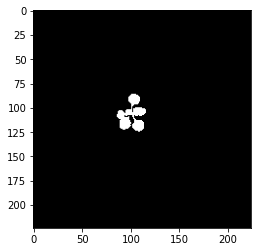

Prediction


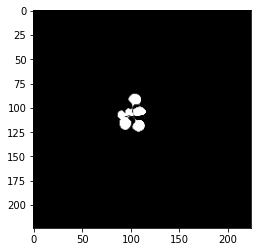

--------------------------------------------------
Ground truth


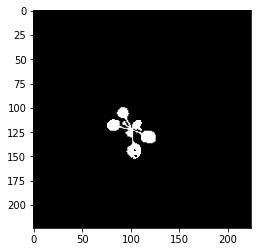

Prediction


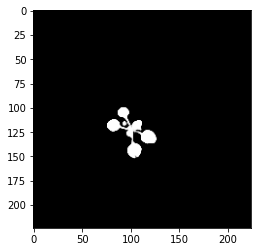

--------------------------------------------------
Ground truth


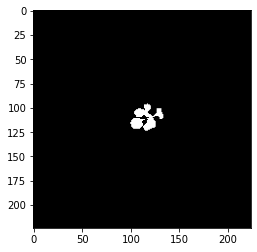

Prediction


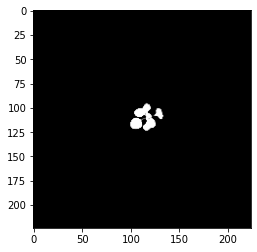

--------------------------------------------------
Ground truth


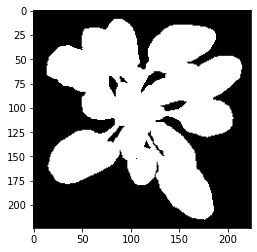

Prediction


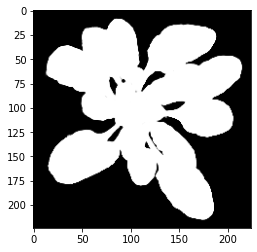

--------------------------------------------------
Ground truth


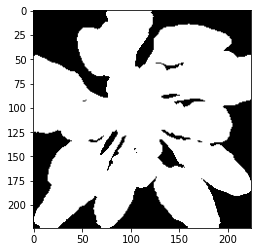

Prediction


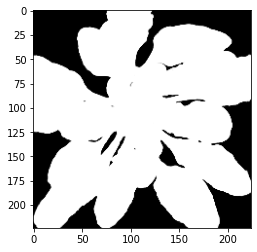

--------------------------------------------------
Ground truth


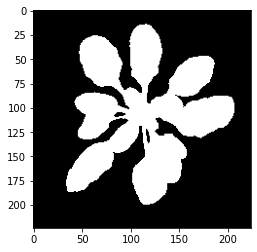

Prediction


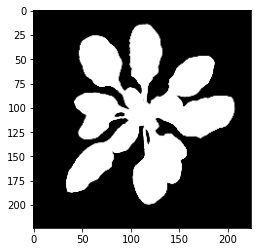

--------------------------------------------------


In [23]:
# Best results
print("Ground truth")
plt.imshow(y_test_images[indexes[1]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[1]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

print("Ground truth")
plt.imshow(y_test_images[indexes[2]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[2]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

print("Ground truth")
plt.imshow(y_test_images[indexes[3]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[3]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

# Worst results
print("Ground truth")
plt.imshow(y_test_images[indexes[-1]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[-1]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

print("Ground truth")
plt.imshow(y_test_images[indexes[-2]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[-2]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

print("Ground truth")
plt.imshow(y_test_images[indexes[-3]][:,:,0], cmap='gray')
plt.show()
print("Prediction")
plt.imshow(predictions[indexes[-3]][:,:,0], cmap='gray')
plt.show()
print("-"*50)

In [24]:
data_path = r"../datasets"

checkpoint_path = r"../Model_checkpoints/Model_edge_detection_smaller/"

In [25]:
@tf.function
def get_input_and_images(input_image_path):
    input_image = tf.io.decode_png(tf.io.read_file(input_image_path), channels = 3)
    input_image = tf.image.convert_image_dtype(input_image, tf.float64)
    input_image = tf.image.resize(input_image, [224, 224])
    input_image = tf.reshape(input_image, [224, 224, 3])

    return input_image         
    
def get_input_images_arrays(input_images):
    test_set_input_images = []

    for input_image_path in input_images:
        input_image = get_input_and_images(input_image_path)
        test_set_input_images.append(input_image)

    test_set_input_images = np.array(test_set_input_images)

    return test_set_input_images

In [26]:
best_model = tf.keras.models.load_model(checkpoint_path, custom_objects={"loss": loss, "dice_coefficient": dice_coefficient}) 

image_path = "../datasets/Leaf_tracking/example_1.png"


In [ ]:
input_image = get_input_images_arrays([image_path])
print("Ground truth")
plt.imshow(input_image[0])
plt.show()

predictions = best_model.predict(np.array(input_image))

print("Prediction")
plt.imshow(predictions[0][:,:,0], cmap='gray')
plt.show()
print("-"*50)